In [1]:
%load_ext nb_black

import ABCParse
import anndata
import cellplots as cp
import larry
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import scdiffeq as sdq
import scdiffeq_analyses as sdq_an
import scipy.stats
import seaborn as sns
import torch

from typing import Any, Dict, List, Optional

<IPython.core.display.Javascript object>

In [2]:
h5ad_path = (
    "/home/mvinyard/data/adata.reprocessed_19OCT2023.more_feature_inclusive.h5ad"
)
adata = sdq.io.read_h5ad(h5ad_path)
larry_cmap = larry.pl.InVitroColorMap()._dict

PCA = sdq.io.read_pickle("/home/mvinyard/data/pca_model.pkl")
UMAP = sdq.io.read_pickle("/home/mvinyard/data/umap_model.pkl")

AnnData object with n_obs × n_vars = 130887 × 2492
    obs: 'Library', 'Cell barcode', 'Time point', 'Starting population', 'Cell type annotation', 'Well', 'SPRING-x', 'SPRING-y', 'clone_idx', 'fate_observed', 't0_fated', 'train'
    var: 'gene_ids', 'hv_gene', 'must_include', 'exclude', 'use_genes'
    uns: 'fate_counts', 'h5ad_path', 'time_occupance'
    obsm: 'X_clone', 'X_pca', 'X_umap', 'cell_fate_df'
    layers: 'X_scaled'


/home/mvinyard/.anaconda3/envs/sdq-dev/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator PCA from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


<IPython.core.display.Javascript object>

In [4]:
project_path = "/home/mvinyard/experiments/LARRY.full_dataset/v1/LightningSDE-FixedPotential-RegularizedVelocityRatio/"
project = sdq.io.Project(path=project_path)
best_ckpts = sdq_an.parsers.best_checkpoints(project)
best_ckpts

,train,test,ckpt_path,epoch
version_0,0.571656,0.551804,/home/mvinyard/experiments/LARRY.full_dataset/...,2500
version_1,0.541401,0.465658,/home/mvinyard/experiments/LARRY.full_dataset/...,1706
version_2,0.547771,0.499418,/home/mvinyard/experiments/LARRY.full_dataset/...,1238
version_3,0.496815,0.504075,/home/mvinyard/experiments/LARRY.full_dataset/...,1245
version_4,0.562102,0.522701,/home/mvinyard/experiments/LARRY.full_dataset/...,1662


<IPython.core.display.Javascript object>

In [5]:
Perturbed = {}
for version, row in best_ckpts.iterrows():
    model = sdq.io.load_model(adata=adata, ckpt_path=row["ckpt_path"])
    break

 - [INFO] | Input data configured.
 - [INFO] | Bulding Annoy kNN Graph on adata.obsm['train']


Seed set to 0


 - [INFO] | Using the specified parameters, LightningSDE-FixedPotential-RegularizedVelocityRatio has been called.


<IPython.core.display.Javascript object>

In [6]:
result = sdq.tl.perturb_scan_z_range(
    adata=adata,
    model=model,
    obs_key="Cell type annotation",
    subset_key="Cell type annotation",
    subset_val="Undifferentiated",
    genes=["Cebpe", "Dach1", "Lmo4", "Mxd1"],
    t_sim=torch.linspace(2, 6, 41),
    z_range=np.linspace(-10, 10, 9),
    PCA=PCA,
    N=200,
    replicates=10,
    seed=0,
)

<IPython.core.display.Javascript object>

In [33]:
mon = {key: val.prtb.loc["Monocyte"].values.tolist() for key, val in result.items()}
neu = {key: val.prtb.loc["Neutrophil"].values.tolist() for key, val in result.items()}

<IPython.core.display.Javascript object>

In [34]:
class StylishBoxPlot(ABCParse.ABCParse):
    def __init__(
        self,
        colors: Optional[List[str]] = None,
        widths: Optional[float] = None,
        scatter_kw={
            "alpha": 0.8,
            "s": 25,
        },
        *args,
        **kwargs
    ):
        self.__parse__(locals())

    @property
    def colors(self):
        if not hasattr(self, "_colors") or self._colors is None:
            self._colors = list(cm.tab20.colors)
        return self._colors

    def _background_scatter(self, ax, data):
        for en, (key, val) in enumerate(data.items()):

            x = [key] * len(val)

            if len(x) > 1:
                x_vals = en + 1 + (np.random.random(len(x)) - 0.5) / 5
            else:
                x_vals = en + 1

            ax.scatter(
                x_vals,
                val,
                color=self.colors[en],
                zorder=0,
                ec="None",
                rasterized=False,
                **self._scatter_kw,
            )

    def _background_boxplot(self, ax, data):

        x = list(data.keys())
        y = list(data.values())

        x = np.arange(len(y)) + 1

        bp = ax.boxplot(
            y,
            positions=x,
            patch_artist=True,
            showmeans=True,
            showfliers=False,
            meanline=True,
            zorder=1,
            widths=self._widths,
        )
        for median in bp["medians"]:
            median.set_visible(False)
        for en, mean in enumerate(bp["means"]):
            mean.set_c(self.colors[en])

        for en, box in enumerate(bp["boxes"]):
            box.set_facecolor(self.colors[en])
            box.set_alpha(0.2)

        for en, whisker in enumerate(bp["whiskers"]):
            whisker.set_c("None")

        for en, cap in enumerate(bp["caps"]):
            cap.set_c("None")

    def _foreground_boxplot(self, ax, data):

        y = list(data.values())
        x = list(data.keys())
        x = np.arange(len(y)) + 1
        bp = ax.boxplot(
            y,
            positions=x,
            patch_artist=True,
            showmeans=False,
            showfliers=False,
            meanline=False,
            zorder=2,
            widths=self._widths,
        )
        for en, box in enumerate(bp["boxes"]):
            box.set_facecolor("None")
            box.set_edgecolor(self.colors[en])

        colors_ = np.repeat(
            np.array(self.colors), 2, axis=0
        )  # list(np.repeat(self.colors, 2))
        for en, whisker in enumerate(bp["whiskers"]):
            whisker.set_c(colors_[en])

        for en, cap in enumerate(bp["caps"]):
            cap.set_c(colors_[en])

        for median in bp["medians"]:
            median.set_visible(False)

    def __call__(self, ax, data, *args, **kwargs):

        self.__update__(locals())

        try:
            self._background_scatter(ax, data)
        except:
            print(data)
        self._background_boxplot(ax, data)
        self._foreground_boxplot(ax, data)

<IPython.core.display.Javascript object>

In [35]:
x = [0, 2.5, 5, 7.5, 10, -2.5, -5, -7.5, -10]
mon_x = {xi: mon[xi] for xi in x}
neu_x = {xi: neu[xi] for xi in x}

<IPython.core.display.Javascript object>

In [43]:
colors = [
    "#f5f6f6",
    "#96d2b1",
    "#4FB587",
    "#377D5D",
    "#1E4433",
    "#f48da2",
    "#C81F4C",
    "#911738",
    "#5A0F24",
]

<IPython.core.display.Javascript object>

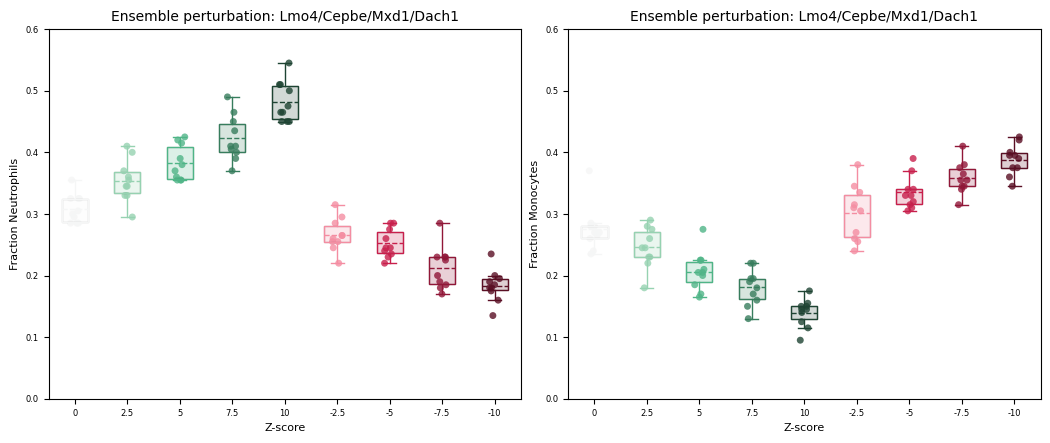

<IPython.core.display.Javascript object>

In [47]:
fig, axes = cp.plot(
    nplots=2,
    ncols=2,
    wspace=0.1,
    y_label=["Fraction Neutrophils", "Fraction Monocytes"],
    title=[
        "Ensemble perturbation: Lmo4/Cepbe/Mxd1/Dach1",
    ],
    x_label=["Z-score"],
)
bp = StylishBoxPlot(colors=colors)
bp(ax=axes[0], data=neu_x)
bp = StylishBoxPlot(colors=colors)
bp(ax=axes[1], data=mon_x)
for ax in axes:
    ax.set_ylim(0, 0.6)
    ax.set_xticks(range(1, len(x) + 1))
    ax.set_xticklabels([str(xi) for xi in x])

plt.savefig("Figure3CD.LARRY.z_scan.tf_perturbation.svg", dpi=500)

### Stats: Z=-10.0

In [51]:
result[-10].stats

,lfc,lfc_std,pval
Baso,-0.344163,0.464065,6.334807e-02
Ccr7_DC,-2.225350,7.037174,3.434364e-01
Eos,0.100000,10.728173,6.619521e-01
Lymphoid,-2.225350,12.632113,5.565650e-01
Mast,0.049185,0.542898,7.071420e-01
Meg,-0.388254,0.996793,2.465738e-01
Monocyte,0.503497,0.165400,7.803902e-07
Neutrophil,-0.716182,0.219733,2.822856e-08
Undifferentiated,0.213196,0.294746,5.978327e-02


<IPython.core.display.Javascript object>

### Stats: Z=-7.5

In [52]:
result[-7.5].stats

,lfc,lfc_std,pval
Baso,-0.357732,0.426074,0.063345
Ccr7_DC,-2.225350,7.037174,0.343436
Eos,2.325350,12.810971,0.411768
Lymphoid,0.000000,14.835665,1.000000
Mast,-0.101994,0.642909,0.666921
Meg,-0.293650,0.895389,0.322376
Monocyte,0.388769,0.169799,0.000030
Neutrophil,-0.507302,0.225406,0.000010
Undifferentiated,0.257598,0.283954,0.006670


<IPython.core.display.Javascript object>

### Stats: Z=-5.0

In [53]:
result[-5].stats

,lfc,lfc_std,pval
Baso,-0.298958,0.320706,0.050857
Ccr7_DC,-2.225350,7.037174,0.343436
Eos,2.325350,12.810971,0.411768
Lymphoid,-2.225350,12.632113,0.556565
Mast,0.051255,0.516998,0.729008
Meg,-0.242112,0.808106,0.291466
Monocyte,0.290306,0.201228,0.000859
Neutrophil,-0.250560,0.172126,0.000836
Undifferentiated,0.088532,0.272041,0.335660


<IPython.core.display.Javascript object>

### Stats: Z=-2.5

In [54]:
result[-2.5].stats

,lfc,lfc_std,pval
Baso,-0.285827,0.335098,0.069205
Ccr7_DC,-2.225350,7.037174,0.343436
Eos,4.550699,14.217715,0.239034
Lymphoid,-2.225350,12.632113,0.556565
Mast,0.078241,0.510552,0.565435
Meg,-0.134875,0.656334,0.495795
Monocyte,0.127975,0.194121,0.177587
Neutrophil,-0.173706,0.161797,0.014792
Undifferentiated,0.183716,0.282854,0.045200


<IPython.core.display.Javascript object>

### Stats: Z=0 (negative control)

In [57]:
result[0].stats

,lfc,lfc_std,pval
Baso,-0.329532,0.350264,0.062290
Ccr7_DC,-2.225350,7.037174,0.343436
Eos,4.550699,14.217715,0.239034
Lymphoid,-2.225350,12.632113,0.556565
Mast,0.123756,0.447023,0.393449
Meg,-0.093901,0.579420,0.562036
Monocyte,0.001702,0.232710,1.000000
Neutrophil,0.043065,0.150576,0.484823
Undifferentiated,0.058939,0.267663,0.521007


<IPython.core.display.Javascript object>

### Stats: Z=+2.5

In [58]:
result[2.5].stats

,lfc,lfc_std,pval
Baso,-0.403819,0.333990,0.009848
Ccr7_DC,-2.225350,7.037174,0.343436
Eos,9.159895,15.814315,0.065820
Lymphoid,-2.225350,12.632113,0.556565
Mast,0.054175,0.527476,0.693671
Meg,-0.179211,0.692902,0.425182
Monocyte,-0.166468,0.163012,0.073626
Neutrophil,0.239194,0.105876,0.001354
Undifferentiated,0.001625,0.289195,1.000000


<IPython.core.display.Javascript object>

### Stats: Z=+5.0

In [59]:
result[5].stats

,lfc,lfc_std,pval
Baso,-0.267582,0.372348,0.124908
Ccr7_DC,-2.225350,7.037174,0.343436
Eos,2.383846,12.918037,0.370888
Lymphoid,-2.225350,12.632113,0.556565
Mast,0.004420,0.582175,0.900783
Meg,0.036657,0.728058,0.769546
Monocyte,-0.418199,0.278190,0.000333
Neutrophil,0.353356,0.106797,0.000005
Undifferentiated,-0.026492,0.247384,0.851797


<IPython.core.display.Javascript object>

### Stats: Z=+7.5

In [60]:
result[7.5].stats

,lfc,lfc_std,pval
Baso,-0.407182,0.371657,1.167101e-02
Ccr7_DC,-2.225350,7.037174,3.434364e-01
Eos,2.325350,12.810971,4.117681e-01
Lymphoid,-2.225350,12.632113,5.565650e-01
Mast,-0.005319,0.627175,9.086113e-01
Meg,0.103583,0.735823,5.163128e-01
Monocyte,-0.611540,0.285579,8.386557e-06
Neutrophil,0.495526,0.076474,2.386503e-07
Undifferentiated,-0.089762,0.348114,3.469466e-01


<IPython.core.display.Javascript object>

### Stats: Z=+10.0

In [61]:
result[10].stats

,lfc,lfc_std,pval
Baso,-0.474214,0.246406,3.394814e-04
Ccr7_DC,-2.225350,7.037174,3.434364e-01
Eos,6.776049,10.913870,1.274668e-01
Lymphoid,-2.225350,12.632113,5.565650e-01
Mast,0.047206,0.632534,6.553308e-01
Meg,0.110495,0.555091,5.748016e-01
Monocyte,-0.988180,0.285764,7.556143e-08
Neutrophil,0.687548,0.100663,1.406881e-10
Undifferentiated,-0.218872,0.199491,2.798487e-02


<IPython.core.display.Javascript object>